In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import paddle
from paddle.io import Dataset
from paddle.nn import Conv2D, MaxPool2D, Linear, Dropout, BatchNorm, AdaptiveAvgPool2D, AvgPool2D
import paddle.nn.functional as F
import paddle.nn as nn

class PatchEmbed(nn.Layer):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * \
            (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2D(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            "Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose((0, 2, 1))
        return x

In [2]:
class Attention(nn.Layer):
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        self.qkv = nn.Linear(dim, dim * 3, bias_attr=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        N, C = x.shape[1:]
        qkv = self.qkv(x).reshape((-1, N, 3, self.num_heads, C //
                                   self.num_heads)).transpose((2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q.matmul(k.transpose((0, 1, 3, 2)))) * self.scale
        attn = nn.functional.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)
        x = (attn.matmul(v)).transpose((0, 2, 1, 3)).reshape((-1, N, C))
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [3]:
class Mlp(nn.Layer):
    def __init__(self,
                 in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.GELU,
                 drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [4]:
def drop_path(x, drop_prob=0., training=False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = paddle.to_tensor(1 - drop_prob)
    shape = (paddle.shape(x)[0], ) + (1, ) * (x.ndim - 1)
    random_tensor = keep_prob + paddle.rand(shape, dtype=x.dtype)
    random_tensor = paddle.floor(random_tensor)
    output = x.divide(keep_prob) * random_tensor
    return output

class DropPath(nn.Layer):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [5]:
class Block(nn.Layer):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 act_layer=nn.GELU,
                 norm_layer='nn.LayerNorm',
                 epsilon=1e-5):
        super().__init__()
        self.norm1 = eval(norm_layer)(dim, epsilon=epsilon)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else Identity()
        self.norm2 = eval(norm_layer)(dim, epsilon=epsilon)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim,
                       hidden_features=mlp_hidden_dim,
                       act_layer=act_layer,
                       drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [6]:
trunc_normal_ = nn.initializer.TruncatedNormal(std=.02)
zeros_ = nn.initializer.Constant(value=0.)
ones_ = nn.initializer.Constant(value=1.)

def to_2tuple(x):
    return tuple([x] * 2)

class Identity(nn.Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, input):
        return input

In [7]:
class VisionTransformer(nn.Layer):
    def __init__(self,
                 img_size=384,
                 patch_size=16,
                 in_chans=3,
                 class_dim=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 norm_layer='nn.LayerNorm',
                 epsilon=1e-5,
                 **args):
        super().__init__()
        self.class_dim = class_dim

        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = self.create_parameter(
            shape=(1, num_patches + 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("pos_embed", self.pos_embed)

        self.cls_token = self.create_parameter(
            shape=(1, 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("cls_token", self.cls_token)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = np.linspace(0, drop_path_rate, depth)
     
        self.blocks = nn.LayerList([
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
                epsilon=epsilon) for i in range(depth)
        ])

        self.norm = eval(norm_layer)(embed_dim, epsilon=epsilon)

        self.head = nn.Linear(embed_dim,
                              class_dim) if class_dim > 0 else Identity()

        trunc_normal_(self.pos_embed)
        trunc_normal_(self.cls_token)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            zeros_(m.bias)
            ones_(m.weight)
  
    def forward_features(self, x):
        B = paddle.shape(x)[0]

        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand((B, -1, -1))
        x = paddle.concat((cls_tokens, x), axis=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)

        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [8]:
!tar -xf /home/aistudio/data/data105740/ILSVRC2012_val.tar -C work/
!unzip -q -o /home/aistudio/data/data105741/pretrained.zip -d work/

In [9]:
def decode_image(img, to_rgb=True):
    data = np.frombuffer(img, dtype='uint8')
    img = cv2.imdecode(data, 1)
    if to_rgb:
        assert img.shape[2] == 3, 'invalid shape of image[%s]' % (
            img.shape)
        img = img[:, :, ::-1]

    return img

def resize_image(img, size=None, resize_short=None, interpolation=-1):
    interpolation = interpolation if interpolation >= 0 else None
    if resize_short is not None and resize_short > 0:
        resize_short = resize_short
        w = None
        h = None
    elif size is not None:
        resize_short = None
        w = size if type(size) is int else size[0]
        h = size if type(size) is int else size[1]
    else:
        raise ValueError("invalid params for ReisizeImage for '\
            'both 'size' and 'resize_short' are None")

    img_h, img_w = img.shape[:2]
    if resize_short is not None:
        percent = float(resize_short) / min(img_w, img_h)
        w = int(round(img_w * percent))
        h = int(round(img_h * percent))
    else:
        w = w
        h = h
    if interpolation is None:
        return cv2.resize(img, (w, h))
    else:
        return cv2.resize(img, (w, h), interpolation=interpolation)

def crop_image(img, size):
    if type(size) is int:
        size = (size, size)
    else:
        size = size  # (h, w)

    w, h = size
    img_h, img_w = img.shape[:2]
    w_start = (img_w - w) // 2
    h_start = (img_h - h) // 2

    w_end = w_start + w
    h_end = h_start + h
    return img[h_start:h_end, w_start:w_end, :]

def normalize_image(img, scale=None, mean=None, std=None, order= ''):
    if isinstance(scale, str):
        scale = eval(scale)
    scale = np.float32(scale if scale is not None else 1.0 / 255.0)
    mean = mean if mean is not None else [0.485, 0.456, 0.406]
    std = std if std is not None else [0.229, 0.224, 0.225]

    shape = (3, 1, 1) if order == 'chw' else (1, 1, 3)
    mean = np.array(mean).reshape(shape).astype('float32')
    std = np.array(std).reshape(shape).astype('float32')

    if isinstance(img, Image.Image):
        img = np.array(img)
    assert isinstance(img, np.ndarray), "invalid input 'img' in NormalizeImage"
    return (img.astype('float32') * scale - mean) / std

def to_CHW_image(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    return img.transpose((2, 0, 1))

# 图像预处理方法汇总
def transform(data, mode='train'):

    # 图像解码
    data = decode_image(data)
    # 图像缩放
    data = resize_image(data, resize_short=384)
    # 图像裁剪
    data = crop_image(data, size=384)
    # 标准化
    data = normalize_image(data, scale=1./255., mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # 通道变换
    data = to_CHW_image(data)
    return data



In [10]:
def get_file_list(file_list):
    with open(file_list) as flist:
        full_lines = [line.strip() for line in flist]

    return full_lines

class CommonDataset(Dataset):
    def __init__(self, data_dir, file_list):
        self.full_lines = get_file_list(file_list)
        self.delimiter = ' '
        self.num_samples = len(self.full_lines)
        self.data_dir = data_dir
        return

    def __getitem__(self, idx):
        line = self.full_lines[idx]
        img_path, label = line.split(self.delimiter)
        img_path = os.path.join(self.data_dir, img_path)
        with open(img_path, 'rb') as f:
            img = f.read()
        
        transformed_img = transform(img)
        return (transformed_img, int(label))

    def __len__(self):
        return self.num_samples

DATADIR = '/home/aistudio/work/ILSVRC2012_val/'
VAL_FILE_LIST = '/home/aistudio/work/ILSVRC2012_val/val_list.txt'

val_dataset = CommonDataset(DATADIR, VAL_FILE_LIST)

val_loader = paddle.io.DataLoader(val_dataset, batch_size=2, num_workers=1, drop_last=True)

img, label = next(val_loader())
img.shape, label.shape

([2, 3, 384, 384], [2])

In [11]:
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

print('start evaluation .......')

model = VisionTransformer(
        patch_size=16,
        class_dim=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        qkv_bias=True,
        epsilon=1e-6)

params_file_path="/home/aistudio/work/ViT_base_patch16_384_pretrained.pdparams"
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)

model.eval()

acc_set = []
avg_loss_set = []
for batch_id, data in enumerate(val_loader()):
    x_data, y_data = data
    y_data = y_data.reshape([-1, 1])
    img = paddle.to_tensor(x_data)
    label = paddle.to_tensor(y_data)
  
    logits = model(img)
   
    pred = F.softmax(logits)

    loss_func = paddle.nn.CrossEntropyLoss(reduction='none')
    loss = loss_func(logits, label)

    acc = paddle.metric.accuracy(pred, label)

    acc_set.append(acc.numpy())
    avg_loss_set.append(loss.numpy())
print("[validation] accuracy/loss: {}/{}".format(np.mean(acc_set), np.mean(avg_loss_set)))

start evaluation .......


W0822 11:42:40.484688   302 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0822 11:42:40.490772   302 device_context.cc:422] device: 0, cuDNN Version: 7.6.


[validation] accuracy/loss: 0.8414000272750854/0.5904493927955627


Ground truth lable index: 65, Pred label index:65


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


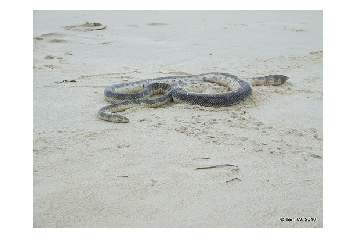

In [12]:
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

model = VisionTransformer(
        patch_size=16,
        class_dim=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        qkv_bias=True,
        epsilon=1e-6)

params_file_path="/home/aistudio/work/ViT_base_patch16_384_pretrained.pdparams"
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)

model.eval()

with open('/home/aistudio/work/ILSVRC2012_val/val_list.txt') as flist:
    line = flist.readline()
img_path, label = line.split(' ')
img_path = os.path.join('/home/aistudio/work/ILSVRC2012_val/', img_path)
with open(img_path, 'rb') as f:
    img = f.read()
transformed_img = transform(img)
true_label = int(label)
x_data = paddle.to_tensor(transformed_img[np.newaxis,:, : ,:])
logits = model(x_data)
pred = F.softmax(logits)
pred_label = int(np.argmax(pred.numpy()))
print("Ground truth lable index: {}, Pred label index:{}".format(true_label, pred_label))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
#DeiT
class DistilledVisionTransformer(VisionTransformer):
    def __init__(self,
                 img_size=384,
                 patch_size=16,
                 class_dim=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4,
                 qkv_bias=False,
                 norm_layer='nn.LayerNorm',
                 epsilon=1e-5,
                 **kwargs):
        # ViT 结构
        super().__init__(
            img_size=img_size,
            patch_size=patch_size,
            class_dim=class_dim,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            norm_layer=norm_layer,
            epsilon=epsilon,
            **kwargs)
      
        self.pos_embed = self.create_parameter(
            shape=(1, self.patch_embed.num_patches + 2, self.embed_dim),
            default_initializer=zeros_)
        self.add_parameter("pos_embed", self.pos_embed)
        # distillation token
        self.dist_token = self.create_parameter(
            shape=(1, 1, self.embed_dim), default_initializer=zeros_)
        self.add_parameter("cls_token", self.cls_token)
        # Classifier head
        self.head_dist = nn.Linear(
            self.embed_dim,
            self.class_dim) if self.class_dim > 0 else Identity()

        trunc_normal_(self.dist_token)
        trunc_normal_(self.pos_embed)
        self.head_dist.apply(self._init_weights)
   
    def forward_features(self, x):
        B = paddle.shape(x)[0]
        
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand((B, -1, -1))
        dist_token = self.dist_token.expand((B, -1, -1))
        x = paddle.concat((cls_tokens, dist_token, x), axis=1)
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
      
        for blk in self.blocks:
            x = blk(x)
  
        x = self.norm(x)
       
        return x[:, 0], x[:, 1]

    def forward(self, x):
        x, x_dist = self.forward_features(x)
        x = self.head(x)
        x_dist = self.head_dist(x_dist)
       
        return (x + x_dist) / 2

In [14]:
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

print('start evaluation .......')

model = DistilledVisionTransformer(
        patch_size=16,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        qkv_bias=True,
        epsilon=1e-6)

params_file_path="/home/aistudio/work/DeiT_base_distilled_patch16_384_pretrained.pdparams"
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)

model.eval()

acc_set = []
avg_loss_set = []
for batch_id, data in enumerate(val_loader()):
    x_data, y_data = data
    y_data = y_data.reshape([-1, 1])
    img = paddle.to_tensor(x_data)
    label = paddle.to_tensor(y_data)
    
    logits = model(img)
    
    pred = F.softmax(logits)
    
    loss_func = paddle.nn.CrossEntropyLoss(reduction='none')
    loss = loss_func(logits, label)
   
    acc = paddle.metric.accuracy(pred, label)

    acc_set.append(acc.numpy())
    avg_loss_set.append(loss.numpy())
print("[validation] accuracy/loss: {}/{}".format(np.mean(acc_set), np.mean(avg_loss_set)))

start evaluation .......
[validation] accuracy/loss: 0.8505600094795227/0.5970645546913147


Ground truth lable index: 65, Pred label index:65


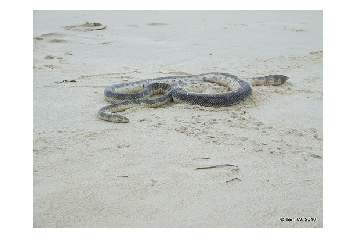

In [15]:
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

model = DistilledVisionTransformer(
        patch_size=16,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        qkv_bias=True,
        epsilon=1e-6)

params_file_path="/home/aistudio/work/DeiT_base_distilled_patch16_384_pretrained.pdparams"
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)

model.eval()

with open('/home/aistudio/work/ILSVRC2012_val/val_list.txt') as flist:
    line = flist.readline()
img_path, label = line.split(' ')
img_path = os.path.join('/home/aistudio/work/ILSVRC2012_val/', img_path)
with open(img_path, 'rb') as f:
    img = f.read()
transformed_img = transform(img)
true_label = int(label)
x_data = paddle.to_tensor(transformed_img[np.newaxis,:, : ,:])
logits = model(x_data)
pred = F.softmax(logits)
pred_label = int(np.argmax(pred.numpy()))
print("Ground truth lable index: {}, Pred label index:{}".format(true_label, pred_label))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()